<a href="https://colab.research.google.com/github/zayedrmdn/AI-RAG/blob/main/AI_Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas scikit-learn matplotlib seaborn
!pip install keras tensorflow


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/ai4i2020.csv')

# Take a look at the first few rows
df.head()

# Check for missing values
df.isnull().sum()


,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [16]:
df = df.drop('Machine failure', axis=1)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0


In [23]:
# TWF (Tool Wear Failure)
df['TWF'] = ((df['Tool wear [min]'] >= 200) & (df['Tool wear [min]'] <= 240)).astype(int)

# HDF (Heat Dissipation Failure)
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['HDF'] = ((df['temp_diff'] < 8.6) & (df['Rotational speed [rpm]'] < 1380)).astype(int)

# PWF (Power Failure)
df['power'] = df['Torque [Nm]'] * (df['Rotational speed [rpm]'] * 2 * np.pi / 60)
df['PWF'] = ((df['power'] < 3500) | (df['power'] > 9000)).astype(int)

# OSF (Overstrain Failure)
df['OSF'] = (((df['Type'] == 'L') & (df['Tool wear [min]'] * df['Torque [Nm]'] > 11000)) |
             ((df['Type'] == 'M') & (df['Tool wear [min]'] * df['Torque [Nm]'] > 12000)) |
             ((df['Type'] == 'H') & (df['Tool wear [min]'] * df['Torque [Nm]'] > 13000))).astype(int)

# RNF (Random Failure)
np.random.seed(42)
df['RNF'] = (np.random.rand(len(df)) < 0.001).astype(int)

# Create a binary column for 'machine failure' (if any failure mode is true)
df['machine_failure'] = (df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) > 0).astype(int)

df.tail()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,power,machine_failure,TWF1,Temp_diff,temp_diff,temp_diff
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,4955.129373,0,0,9.6,9.6,9.6
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,5434.703963,0,0,9.5,9.5,9.5
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,5753.617506,0,0,9.6,9.6,9.6
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,7151.102638,0,0,9.7,9.7,9.7
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,6314.601234,0,0,9.7,9.7,9.7


In [36]:

df.head()  # To check the result


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],machine_failure,TWF,HDF,PWF,OSF,RNF,power,Temp_diff
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,6951.590560,10.5
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,6826.722724,10.5
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,7749.387543,10.4
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,5927.504659,10.4
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,5897.816608,10.5


In [39]:
# Features
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]

y = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]


Machine Failure Accuracy & Failure Mode Accuracy

In [51]:
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a RandomForestClassifier for multi-label classification
rf_multi = RandomForestClassifier(random_state=42)
multi_target_rf = MultiOutputClassifier(rf_multi, n_jobs=-1)

# Train the model
multi_target_rf.fit(X_train, y_train[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']])

# Predictions for the specific failure modes
y_pred = multi_target_rf.predict(X_test)

# Create a DataFrame for predictions
y_pred_df = pd.DataFrame(y_pred, columns=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# Evaluate each failure mode
for i, col in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF']):
    print(f"Classification report for {col}:")
    print(classification_report(y_test[col], y_pred[:, i]))

# Step 1: Infer Machine failure from the predicted failure modes
y_test['Machine failure inferred'] = (y_test[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) > 0).astype(int)
y_pred_df['Machine failure predicted'] = (y_pred_df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) > 0).astype(int)

# Step 2: Evaluate the accuracy of Machine failure prediction
print("Classification report for Machine Failure:")
print(classification_report(y_test['Machine failure inferred'], y_pred_df['Machine failure predicted']))

# Accuracy for machine failure
accuracy_machine_failure = accuracy_score(y_test['Machine failure inferred'], y_pred_df['Machine failure predicted'])
print(f"Accuracy for predicting overall machine failure: {accuracy_machine_failure * 100:.2f}%")

# Evaluate accuracy for each individual failure mode
for col in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']:
    accuracy_failure_mode = accuracy_score(y_test[col], y_pred_df[col])
    print(f"Accuracy for predicting {col}: {accuracy_failure_mode * 100:.2f}%")


Classification report for TWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2745
           1       1.00      1.00      1.00       255

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Classification report for HDF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2975
           1       0.95      0.80      0.87        25

    accuracy                           1.00      3000
   macro avg       0.98      0.90      0.93      3000
weighted avg       1.00      1.00      1.00      3000

Classification report for PWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2969
           1       0.96      0.74      0.84        31

    accuracy                           1.00      3000
   macro avg       0.98      0.87  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
import numpy as np

# Input parameters: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
test_input = [[300.7, 310.2, 1364, 65.3, 208]]  # Single input for testing

# Assuming the model is already trained and named `multi_target_rf`

# Make a prediction for the test input
y_pred_test = multi_target_rf.predict(test_input)

# Convert the result to a readable format (array of 0s and 1s for each failure mode)
y_pred_test_df = pd.DataFrame(y_pred_test, columns=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# Infer the overall machine failure (if any failure mode is predicted to be 1)
machine_failure_predicted = (y_pred_test_df.sum(axis=1) > 0).astype(int).values[0]

# Display the results
print(f"Predicted Failure Modes for Input: {test_input[0]}")
print(y_pred_test_df)

if machine_failure_predicted:
    print("Overall Machine Failure: Yes")
else:
    print("Overall Machine Failure: No")


Predicted Failure Modes for Input: [300.7, 310.2, 1364, 65.3, 208]
   TWF  HDF  PWF  OSF  RNF
0    1    0    1    1    0
Overall Machine Failure: Yes


In [47]:
pip install joblib


In [58]:
import joblib

# Export the trained model to a file
joblib.dump(multi_target_rf, 'multi_target_rf_model.pkl')

print("Model exported successfully!")


Model exported successfully!


In [49]:
pip install scikit-learn matplotlib


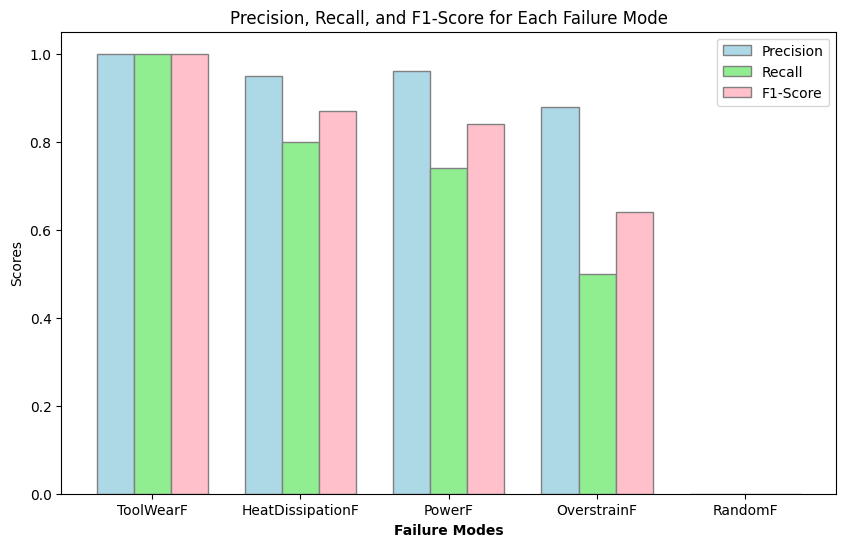

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the classification report

failure_modes = ['ToolWearF', 'HeatDissipationF', 'PowerF', 'OverstrainF', 'RandomF']

# Precision, Recall, F1-scores for each failure mode
precision = [1.00, 0.95, 0.96, 0.88, 0.00]
recall = [1.00, 0.80, 0.74, 0.50, 0.00]
f1_score = [1.00, 0.87, 0.84, 0.64, 0.00]

# Create a bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(failure_modes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plots
plt.figure(figsize=(10,6))
plt.bar(r1, precision, color='lightblue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='lightgreen', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='pink', width=barWidth, edgecolor='grey', label='F1-Score')

# Add labels and title
plt.xlabel('Failure Modes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(failure_modes))], failure_modes)
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for Each Failure Mode')

# Add a legend
plt.legend()

# Show the plot
plt.show()
